In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install faiss-cpu -q
import pandas as pd
import faiss
#=============================
# RAG DB INDEX, METADATA Load
#=============================
INDEX_PATH = '/content/drive/MyDrive/ICT_project/math_problems.index'
METADATA_PATH = '/content/drive/MyDrive/ICT_project/math_problems_metadata.pkl'

FAISS_INDEX = faiss.read_index(INDEX_PATH)
METADATA = pd.read_pickle(METADATA_PATH).reset_index().rename(columns={"index":"vector_id"})

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 49.0 MB/s eta 0:00:00


In [ ]:
# METADATA 불러오기
meta = pd.read_pickle(METADATA_PATH)

# vector_id 컬럼 없으면 새로 생성, 있으면 중복 제거
if "vector_id" not in meta.columns:
    meta = meta.reset_index().rename(columns={"index": "vector_id"})
else:
    # 중복된 vector_id 컬럼이 여러 개라면, 첫 번째만 사용
    if isinstance(meta.columns, pd.MultiIndex):
        meta.columns = ['_'.join([str(c) for c in col]).strip() for col in meta.columns]

    # 혹시라도 vector_id가 중복되면 drop_duplicates로 정리
    meta = meta.loc[:, ~meta.columns.duplicated()]

N = FAISS_INDEX.ntotal

# vector_id가 0..N-1 범위로 정렬되었는지 확인
if meta["vector_id"].nunique() != N:
    print("[경고] 메타데이터 벡터 수와 인덱스 수가 다릅니다.")
    # 필요한 경우: meta = meta.drop_duplicates("vector_id").sort_values("vector_id")

# 벡터 수와 맞게 순서 정렬
meta = meta.sort_values("vector_id").reset_index(drop=True)

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[INFO] Embeddings: (80, 1024)
[INFO] Unique cluster labels: [np.int64(-1), np.int64(0), np.int64(1)]
[INFO] Reduced coords: (80, 2)


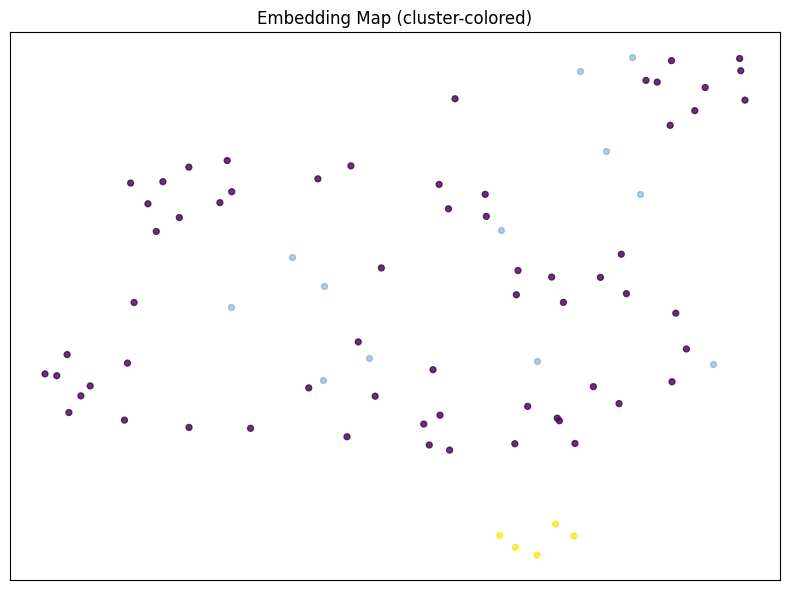

In [ ]:
# ========= 전제 =========
# FAISS_INDEX, (선택) METADATA 이미 로드되어 있다고 가정
# => embeddings_np를 인덱스에서 복원
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# (옵션) UMAP/HDBSCAN 있으면 우선 사용
try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False

try:
    import hdbscan
    HAS_HDBSCAN = True
except Exception:
    HAS_HDBSCAN = False


# 1) 임베딩 복원
def reconstruct_all_embeddings(index) -> np.ndarray:
    n = index.ntotal
    if n == 0:
        return np.zeros((0, index.d), dtype="float32")
    return np.vstack([index.reconstruct(i) for i in range(n)]).astype("float32")

embeddings_np = reconstruct_all_embeddings(FAISS_INDEX)   # shape: (N, 1024)
N = embeddings_np.shape[0]
print(f"[INFO] Embeddings: {embeddings_np.shape}")


# 2) (권장) 원공간에서 군집 찾기
def cluster_in_high_dim(X: np.ndarray, random_state: int = 42) -> np.ndarray:
    """
    우선 HDBSCAN(밀도기반, k 자동추정)을 시도하고,
    미설치/실패 시 KMeans로 대체(k는 sqrt(N) 근사, 2~10 클램핑).
    반환: labels (N,)  # HDBSCAN은 노이즈에 -1 부여
    """
    if HAS_HDBSCAN:
        try:
            clus = hdbscan.HDBSCAN(min_cluster_size=max(4, N // 20),  # 데이터 양에 맞춘 대략값
                                   min_samples=None,                   # 기본
                                   prediction_data=False)
            labels = clus.fit_predict(X)
            # 모든 점이 -1(노이즈)면 KMeans로 폴백
            if (labels >= 0).sum() == 0:
                raise RuntimeError("HDBSCAN produced only noise; fallback to KMeans.")
            return labels
        except Exception as e:
            print(f"[INFO] HDBSCAN fallback → {e}")

    # KMeans fallback
    from sklearn.cluster import KMeans
    k_guess = int(np.sqrt(N))
    k = max(2, min(10, k_guess))
    labels = KMeans(n_clusters=k, n_init=10, random_state=random_state).fit_predict(X)
    return labels

labels = cluster_in_high_dim(embeddings_np)
print(f"[INFO] Unique cluster labels: {sorted(set(labels))}")


# 3) 2D 투영(시각화용) — 군집 라벨은 위에서 이미 확정
def reduce_to_2d(X: np.ndarray, random_state: int = 42) -> np.ndarray:
    if HAS_UMAP:
        reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=random_state)
        return reducer.fit_transform(X)
    try:
        reducer = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=random_state)
        return reducer.fit_transform(X)
    except Exception:
        return PCA(n_components=2, random_state=random_state).fit_transform(X)

Z = reduce_to_2d(embeddings_np)  # shape: (N, 2)
print(f"[INFO] Reduced coords: {Z.shape}")


# 4) 시각화 — 군집 라벨로 색 지정, 축/눈금 제거(점만 보이게)
plt.figure(figsize=(8, 6))

# HDBSCAN의 노이즈(-1)는 연한 회색으로 별도 표시하고 싶다면 두 번 그리기(선택):
if (labels == -1).any():
    mask_noise = (labels == -1)
    plt.scatter(Z[mask_noise, 0], Z[mask_noise, 1], alpha=0.35, s=18, label="noise")  # 색은 기본 팔레트 사용

    mask_core = ~mask_noise
    plt.scatter(Z[mask_core, 0], Z[mask_core, 1], c=labels[mask_core], alpha=0.8, s=18)
else:
    plt.scatter(Z[:, 0], Z[:, 1], c=labels, alpha=0.8, s=18)

plt.title("Embedding Map (cluster-colored)")
plt.xlabel(""); plt.ylabel("")     # 축 라벨 제거
plt.xticks([]); plt.yticks([])     # 눈금 제거
# plt.legend(loc="best", fontsize=8)  # 범례가 필요하면 주석 해제

plt.tight_layout()
plt.show()

In [ ]:
# 1) 크기가 5인 군집(들) 후보 찾기
uniq, cnts = np.unique(labels, return_counts=True)
candidates = uniq[cnts == 5]

if len(candidates) == 0:
    raise ValueError("크기가 5인 군집을 찾지 못했습니다. 노란 군집의 라벨을 직접 지정해 주세요.")

# 2) 후보가 여러 개면 화면에서 '아래쪽'(y 평균이 가장 작은) 군집을 선택
if len(candidates) == 1:
    target_label = candidates[0]
else:
    y_means = [Z[labels == lab, 1].mean() for lab in candidates]
    target_label = candidates[int(np.argmin(y_means))]

print(f"[INFO] 선택된 군집 라벨: {target_label}")

# 3) 해당 군집의 vector_id 인덱스 마스크
mask = (labels == target_label)

# 4) 파일명/텍스트 등 확인
cols_to_show = ["vector_id", "original_filename", "ocr_text"]
available = [c for c in cols_to_show if c in meta.columns]
selected = meta.loc[mask, available]

# 보기 좋게 출력
pd.set_option("display.max_colwidth", 200)
print(selected.to_string(index=False))

[INFO] 선택된 군집 라벨: 1
 vector_id  vector_id                                    original_filename                                                                                                                                           ocr_text
         8          8 2024 수능특강 03.확률의뜻과활용 level2_1.PNG                                                       [23010-0067] 7 한 개의 주사위틀 두 번 던저서 나오는 눈의 수름 차례로 ( , b라 하자. @가 6의 약수일 확출은? 5 1 ' 1 18 3 18 9 2
        11         11 2024 수능특강 03.확률의뜻과활용 level2_4.PNG        [23010-0070] 4 한 개의 주사위틀 한 번 던저 나오는 눈의 수름 확인하는 시행의 두 사건 A, B가 다음 조건올 만족시키도록 두 사건 A B틀 선택하는 경우의 수름 구하시오. P(AUB)= 1. P(An B)= ! (나) P(A)<P(B)
        49         49    2025 수능특강 03.확률의뜻과활용 유제4.PNG                                                             4 한 개의 주사위틀 두 번 던저서 나오는 눈의 수름 차례로 b라 할 때. 직선 y = - 2+(가 원 3 [24010-0053] 5 12 2 12 3 흙
        63         63 2026 수능특강 03.확률의뜻과활용 level2_3.PNG [25010-0071] 3 한 